In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import random
import pandas
import optuna
from rich.table import Table
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from floOTflix.loader import *
from floOTflix.models import *
from floOTflix.logger import *
from floOTflix.constants import *
from floOTflix.utils import *
from floOTflix.main import *
from floOTflix.models.losses import rmse_loss
DATASET = 'small'

In [11]:
console.log(f'random seed: {SEED}, device: {device}')
(X_train, Y_train), (X_test, Y_test), (m, n), (user_id_map, movie_id_map) = get_dataset(DATASET)

[23:20:35] random seed: 42, device: cpu                                                             ]8;id=198163;file:///var/folders/23/phdc9zdx6bd4kxsb9bfjxbmc0000gn/T/ipykernel_64599/1967804857.py\1967804857.py]8;;\:]8;id=555230;file:///var/folders/23/phdc9zdx6bd4kxsb9bfjxbmc0000gn/T/ipykernel_64599/1967804857.py#1\1]8;;\

In [12]:
def load_tags(n_tags, movie_id_map):
    df = pandas.read_csv('ml-latest-large/genome-scores.csv')
    tags = []

    # Takings the more useful tags using STD
    for i_tag, sub_df in df.groupby('tagId'):
        tags.append((i_tag, sub_df['relevance'].std()))
    tags = [i_tag for i_tag,_ in sorted(tags)[-n_tags:]]
    tags = {t:i for i,t in enumerate(tags)}
    df.movieId = df.movieId.map(movie_id_map)
    df.tagId = df.tagId.map(tags)
    df = df.dropna()
    print(df.head(30))

load_tags(10, movie_id_map)

      movieId  tagId  relevance
1118    481.0    0.0    0.03775
1119    481.0    1.0    0.02250
1120    481.0    2.0    0.04075
1121    481.0    3.0    0.03175
1122    481.0    4.0    0.12950
1123    481.0    5.0    0.04550
1124    481.0    6.0    0.02000
1125    481.0    7.0    0.03850
1126    481.0    8.0    0.09125
1127    481.0    9.0    0.02225
2246      1.0    0.0    0.04775
2247      1.0    1.0    0.02050
2248      1.0    2.0    0.01650
2249      1.0    3.0    0.02450
2250      1.0    4.0    0.13050
2251      1.0    5.0    0.02700
2252      1.0    6.0    0.01825
2253      1.0    7.0    0.01225
2254      1.0    8.0    0.09925
2255      1.0    9.0    0.01850
3374    482.0    0.0    0.05800
3375    482.0    1.0    0.02375
3376    482.0    2.0    0.03550
3377    482.0    3.0    0.02125
3378    482.0    4.0    0.12775
3379    482.0    5.0    0.03250
3380    482.0    6.0    0.01625
3381    482.0    7.0    0.02125
3382    482.0    8.0    0.09525
3383    482.0    9.0    0.01750


In [15]:
mf_model = get_mf_model(DATASET, 'load')
U1, V1 = mf_model.get_features(X_train, Y_train)
deepmf_model = get_deepmf_model(DATASET, 'load')
U2, V2 = deepmf_model.get_features(X_train, Y_train)

U = torch.cat([U1, U2], dim=1)
V = torch.cat([V1, V2], dim=1)

[23:21:29] MF score: 0.7152                                                                              ]8;id=27816;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/main.py\main.py]8;;\:]8;id=523120;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/main.py#26\26]8;;\

           DeepMF score: 0.7995                                                                          ]8;id=262711;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/main.py\main.py]8;;\:]8;id=957193;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/main.py#46\46]8;;\

x torch.Size([96045, 2])


In [17]:
Y_train

tensor([4., 4., 4.,  ..., 5., 5., 3.])

Epoch 0, train error: 2.578942940090201e-06, test error: 2.685327444851282e-06
Epoch 31, train error: 2.582739625722752e-06, test error: 2.690375822567148e-06
Epoch 62, train error: 2.582987917776336e-06, test error: 2.6905811409960734e-06
Epoch 93, train error: 2.583075229267706e-06, test error: 2.6906529910775134e-06
Epoch 124, train error: 2.583119794508093e-06, test error: 2.6906905077339616e-06
Epoch 155, train error: 2.58314639722812e-06, test error: 2.6907121082331287e-06
Epoch 186, train error: 2.5831645871221554e-06, test error: 2.6907273422693834e-06
Epoch 217, train error: 2.5831775474216556e-06, test error: 2.690738028832129e-06
Epoch 248, train error: 2.583186869742349e-06, test error: 2.6907464416581206e-06
Epoch 279, train error: 2.583194600447314e-06, test error: 2.6907521260000067e-06
Epoch 310, train error: 2.5832000574155245e-06, test error: 2.6907566734735155e-06


Text(0.5, 0, 'Epoch')

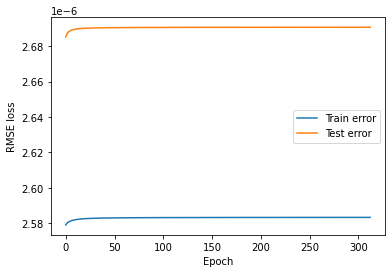

In [19]:
c0 = torch.ones(m, n)
alpha0 = torch.ones(m)
beta0 = torch.ones(n)

y = torch.cat([Y_train, Y_test])
y_train = Y_train / y.sum()
y_test = Y_test / y.sum()

best_params = {'eps': 7.117140576005326,
               'max_clidiot_iter': 313,
               'max_prox_iter': 354,
               'prox_lr': 0.022761152209025193,
               'prox_gamma': 7.97926813515542,
               'prox_reg': 0.2444655698983902,
               'c0': '1e-2',
               'ot_lambda': 7.527066574918035}
best_params = {k: v for k, v in best_params.items() if k not in ('c0', 'alpha0', 'beta0')}

model = CLIDIOTModel(m, n, **best_params, c0=c0,
                     alpha0=alpha0, beta0=beta0, verbose=True)
train_errors, test_errors = model.fit(X_train, y_train, X_test, y_test, U, V)

sns.lineplot(x=np.arange(len(train_errors)),
             y=train_errors, label="Train error")
sns.lineplot(x=np.arange(len(test_errors)), y=test_errors, label="Test error")
plt.ylabel("RMSE loss")
plt.xlabel("Epoch")

In [20]:
clidiot_model = CLIDIOTGradientModel(m, n)
clidiot_model.fit(X_train, Y_train, X_test, Y_test, U=U, V=V,
    eps=1e-4, max_iter=100, lr=1e-1, optimizer='adam')
# score = clidiot_model.score(X_test, Y_test)
# console.log(f'CLIDIOT score: {score:.4f}')

Epoch 0, train loss 3.594303416321054e-05, train error: 0.9066883325576782, test error: 0.966722846031189
Epoch 10, train loss -1.929776999531896e-06, train error: 0.9063957333564758, test error: 0.966151237487793
Epoch 20, train loss -2.7265366497886134e-06, train error: 0.9063854217529297, test error: 0.9661582112312317
Epoch 30, train loss -3.4404351936245803e-06, train error: 0.9063800573348999, test error: 0.9661480188369751
Epoch 40, train loss -4.2420424506417476e-06, train error: 0.9063925743103027, test error: 0.9661465287208557
Epoch 50, train loss -5.072668955108384e-06, train error: 0.9063836932182312, test error: 0.9661487936973572
Epoch 60, train loss -5.9003846217819955e-06, train error: 0.9063853025436401, test error: 0.9661509394645691
Epoch 70, train loss -6.723684236931149e-06, train error: 0.9063865542411804, test error: 0.966152012348175
Epoch 80, train loss -7.544530944869621e-06, train error: 0.906387209892273, test error: 0.9661528468132019
Epoch 90, train loss 

([0.9066883325576782,
  0.9063957333564758,
  0.9063854217529297,
  0.9063800573348999,
  0.9063925743103027,
  0.9063836932182312,
  0.9063853025436401,
  0.9063865542411804,
  0.906387209892273,
  0.9063876271247864],
 [0.966722846031189,
  0.966151237487793,
  0.9661582112312317,
  0.9661480188369751,
  0.9661465287208557,
  0.9661487936973572,
  0.9661509394645691,
  0.966152012348175,
  0.9661528468132019,
  0.9661530256271362])

tensor(1.8300e-10)
tensor(0.0162) tensor(0.0162)


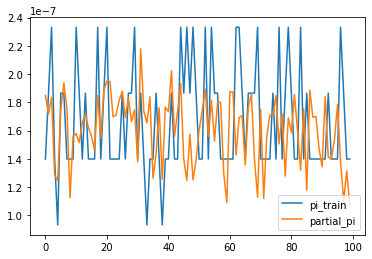

In [21]:
x1, x2 = X_train.T
partial_pi = clidiot_model.partial_pi[:len(X_train)]
pi_train = clidiot_model.pi_train
print(((partial_pi-pi_train)**2).sum().mean().sqrt().item())
print(pi_train.sum(), partial_pi.sum())

i = 600
plt.plot(pi_train.numpy()[i:i+100], label='$\pi_{train}')
plt.plot(partial_pi.numpy()[i:i+100], label='partial_pi')
# plt.plot(pi_pred[x1,x2].numpy()[i:i+200], label='pi_pred[x1,x2]')
plt.legend()
plt.show()

In [27]:
y_test_pred = clidiot_model.predict(X_test, clidiot_model.correlation_matrix)

torch.Size([96045]) torch.Size([610]) torch.Size([9724])


RuntimeError: inconsistent tensor size, expected tensor [96045] and src [610] to have the same number of elements, but got 96045 and 610 elements respectively

In [ ]:


random_indexes = np.random.choice(np.arange(len(y_test)), size=100, replace=False)
y_test_pred_r = y_test_pred[random_indexes]
y_test_r = y_test[random_indexes]
y_random_r = random_pred[random_indexes]
y_mean_r = mean_pred[random_indexes]
y_mf_r = y_pred_mf[random_indexes].detach().numpy()

plt.figure(dpi=300)
# sns.lineplot(x=range(len(random_indexes)), y=y_random_r, label="random")
# sns.lineplot(x=range(len(random_indexes)), y=y_mean_r, label="mean")
sns.lineplot(x=range(len(random_indexes)), y=y_mf_r, label="mf")
sns.lineplot(x=range(len(random_indexes)), y=y_test_pred_r, label="prediction")
sns.lineplot(x=range(len(random_indexes)), y=y_test_r, label="ground truth")
plt.ylabel("value at point $i, j$")
plt.xlabel("index of point $i, j$")
plt.title("Prediction vs ground truth")

In [ ]:
k = U.shape[1]
trial = functools.partial(CLIDIOTModel.optuna_trial, m, n, X_train, Y_train, X_test, Y_test, U, V)
study = optuna.create_study(direction='minimize')
study.optimize(trial, n_trials=100)

In [100]:
study.best_params

{'eps': 4.879723495593808,
 'max_clidiot_iter': 163,
 'max_prox_iter': 296,
 'prox_lr': 9.337572682972917,
 'prox_gamma': 3.711638461142797,
 'prox_reg': 7.336713336391838,
 'c0': 'ones',
 'ot_lambda': 0.1769140284467704}

Epoch 0, train error: 0.9051973819732666, test error: 0.9632509350776672
Epoch 10, train error: 0.9067412614822388, test error: 0.965223491191864
Epoch 20, train error: 0.906741201877594, test error: 0.9652234315872192
Epoch 30, train error: 0.906741201877594, test error: 0.9652233719825745
Epoch 40, train error: 0.906741201877594, test error: 0.965223491191864
Epoch 50, train error: 0.9067412614822388, test error: 0.9652234315872192
Epoch 60, train error: 0.9067412614822388, test error: 0.965223491191864
Epoch 70, train error: 0.9067412614822388, test error: 0.965223491191864
Epoch 80, train error: 0.906741201877594, test error: 0.965223491191864
Epoch 90, train error: 0.906741201877594, test error: 0.965223491191864


<AxesSubplot: >

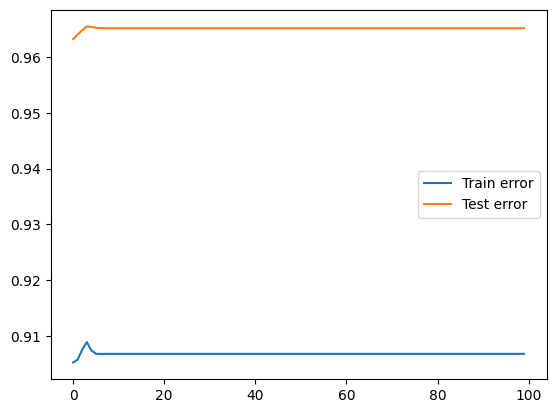

In [126]:
c0 = torch.ones(m, n)
alpha0 = torch.ones(m)
beta0 = torch.ones(n)

best_params = {
    'eps': 1e-1,
    'max_clidiot_iter': 100,
    'max_prox_iter': 100,
    'prox_lr': 1e-2,
    'prox_gamma': 1,
    'prox_reg': 1e-1,
    'ot_lambda': 1,
}

model = CLIDIOTModel(m, n, **best_params, c0=c0, alpha0=alpha0, beta0=beta0, verbose=True)
train_errors, test_errors = model.fit(X_train, Y_train, X_test, Y_test, U, V)

sns.lineplot(x=np.arange(len(train_errors)), y=train_errors, label="Train error")
sns.lineplot(x=np.arange(len(test_errors)), y=test_errors, label="Test error")

In [49]:
Y_rand = (torch.randint(7, (len(Y_test),))+3)/2
Y_same = torch.ones(Y_test.shape) * Y_train.mean()
print('y_rand', rmse_loss(Y_rand, Y_test))
print('y_same', rmse_loss(Y_same, Y_test))

y_rand tensor(1.5659)
y_same tensor(0.9611)
